# visualize z

In [6]:
import json
import os
import torch
import numpy as np
from args import TrainerArguments, ModelArguments
from dataset import GraphDataset
from model import DGLFRM

device = "cuda:0"
# specify the path to the saved model here
with open("./output/visualize_model/args.json", 'r') as file:
    args = json.load(file)

train_args = TrainerArguments(**args['train_args'])
model_args = ModelArguments(**args['model_args'])

dataset = GraphDataset(train_args.dataset, train_args.split_name)
model_args.num_features = dataset.num_features
model = DGLFRM(model_args).to("cuda:0")
model.load_state_dict(torch.load(train_args.best_model_path, device))

<All keys matched successfully>

## compute latent variables

In [7]:
from utils import move_to_cuda

# load node feature matrix and adjacency matrix
data = dataset[0]
x, adj_mat = data["node_features"], data["adj_train"]
data = move_to_cuda({"x": x, "adj_mat": adj_mat}, device)

# encode and reparam
model.eval()
with torch.no_grad():
    latents = model.encode(**data)
    _, pi_logit_post, b, r = model.reparameterize(*latents)
    b = torch.round(b)
    z = (b * r).cpu().numpy()

In [8]:
z_activated_avg = (b.sum() / b.size(0)).item()

print(f"average activated communities: {z_activated_avg:.4f}")
z.shape

average activated communities: 9.9934


(3327, 10)

In [9]:
import matplotlib.pyplot as plt

def plot_communities(image, size, cmap=plt.cm.hot, x_label="Z", y_label='Nodes', y_step = 250, x_step=10, vmin=0, vmax=1):
    fig, ax = plt.subplots(figsize = size)

    img = ax.imshow(image, cmap=cmap, interpolation='nearest', aspect='auto', vmin=vmin, vmax=vmax)
    ax.set_title('')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    ax.set_yticks(np.arange(0, image.shape[0], step=y_step))
    ax.set_xticks(np.arange(0, image.shape[1], step=x_step))

    ax.margins(x=0,y=0)

    cbar = fig.colorbar(img, ax=ax)
    for font_objects in cbar.ax.yaxis.get_ticklabels():
        font_objects.set_size(18)

    fontsize = 18

    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
        tick.label1.set_fontweight('bold')
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
        tick.label1.set_fontweight('bold')

    plt.xlabel(x_label, fontsize=24)#, fontweight='bold')
    plt.ylabel(y_label, fontsize=24)#, fontweight='bold')

    plt.show()

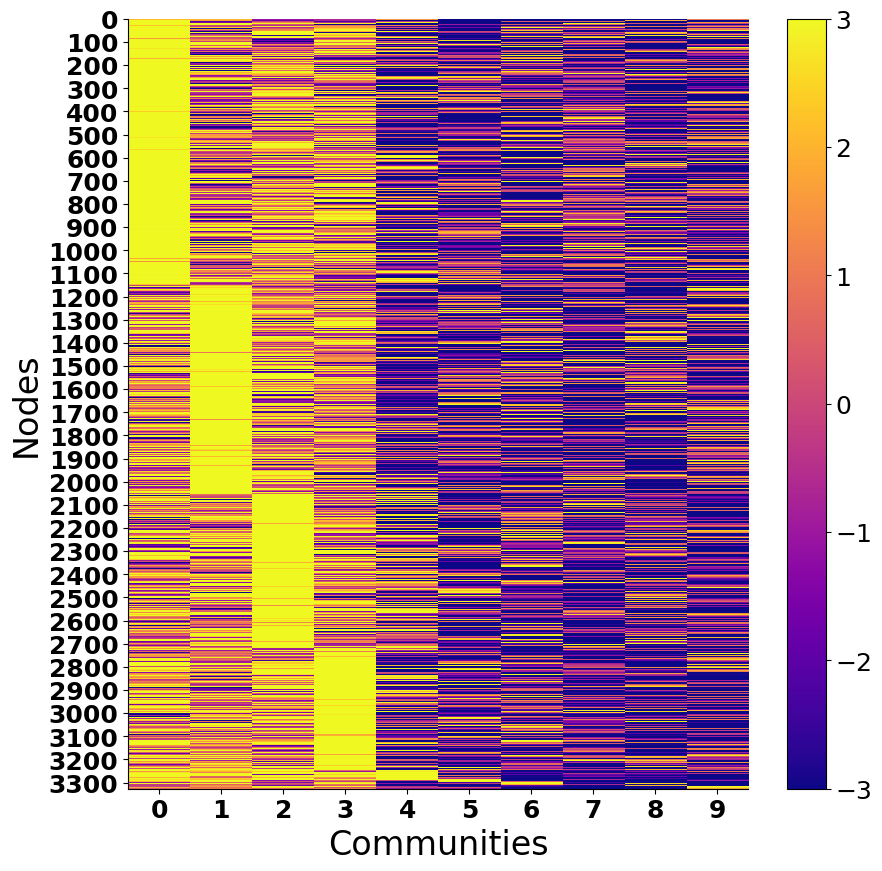

In [10]:
fig_size = (10, 10)

# Reordering the communities (Columns of Z) for visualization.
total_community_strength = np.sum(z, axis=0)
new_community_idx = np.argsort(total_community_strength)[::-1]
z = z[:, new_community_idx] 

# Reordering the nodes (Rows of Z) such that nodes having 
# high strength for communities with lower indices are on top.
max_node_community_idx = np.argmax(z, axis=1)
new_node_idx = np.argsort(max_node_community_idx)
z = z[new_node_idx, :]

plot_communities(z, fig_size, 'plasma', x_step=1, y_step=100, vmin=-3, vmax=3, x_label='Communities')